<a href="https://colab.research.google.com/github/AlexGreco1/knowledge/blob/main/IncidentRootCauseAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install required packages
!pip install pandas
!pip install tensorflow
!pip install sklearn
!pip install matplotlib

In [ ]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#---------------------------------------------------------------------
#Function to convert Flower names to numeric values
#---------------------------------------------------------------------
def type_to_numeric(x):
    if x=='setosa':
        return 0
    if x=='versicolor':
        return 1
    else :
        return 2

#---------------------------------------------------------------------
#Function to read data and process. Get ready for Deep Learning
#---------------------------------------------------------------------
def get_data():
    
    iris_data = pd.read_csv("iris.csv")
    
    iris_data.dtypes
    iris_data.describe()
    iris_data.head()
    
    #Use a Label encoder to convert String to numeric values for the target variable

    label_encoder = preprocessing.LabelEncoder()
    iris_data['Species'] = label_encoder.fit_transform(
                                    iris_data['Species'])
    
    #Convert input to numpy array
    np_iris = iris_data.to_numpy()
    
    #Separate feature and target variables
    X_data = np_iris[:,0:4]
    Y_data=np_iris[:,4]
    
    #Create a scaler model that is fit on the input data.
    scaler = StandardScaler().fit(X_data)
    
    #Scale the numeric feature variables
    X_data = scaler.transform(X_data)
    
    #Convert target variable as a one-hot-encoding array
    Y_data = tf.keras.utils.to_categorical(Y_data,3)

    #Return Feature and Target variables
    return X_data,Y_data

#---------------------------------------------------------------------
#Function to create the default configuration for the model. This will be overridden as 
#required during experimentation
#---------------------------------------------------------------------
def base_model_config():
    model_config = {
            "HIDDEN_NODES" : [32,64],
            "HIDDEN_ACTIVATION" : "relu",
            "OUTPUT_NODES" : 3,
            "OUTPUT_ACTIVATION" : "softmax",
            "WEIGHTS_INITIALIZER" : "random_normal",
            "BIAS_INITIALIZER" : "zeros",
            "NORMALIZATION" : "none",
            "OPTIMIZER" : "rmsprop",
            "LEARNING_RATE" : 0.001,
            "REGULARIZER" : None,
            "DROPOUT_RATE" : 0.0,
            "EPOCHS" : 10,
            "BATCH_SIZE" : 16,
            "VALIDATION_SPLIT" : 0.2,
            "VERBOSE" : 0,
            "LOSS_FUNCTION" : "categorical_crossentropy",
            "METRICS" : ["accuracy"]
            }
    return model_config

#---------------------------------------------------------------------
# Function to create an optimizer based on the optimizer name and learning rate
#---------------------------------------------------------------------
def get_optimizer(optimizer_name, learning_rate):
    #'sgd','rmsprop','adam','adagrad'
    optimizer=None
    
    if optimizer_name == 'adagrad': 
        optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)

    elif 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    elif'adam' :
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        
    else :
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
            
    return optimizer
    
    
#---------------------------------------------------------------------
# Function to create a model and fit the model
#---------------------------------------------------------------------

def create_and_run_model(model_config,X,Y,model_name) :
    
    model=tf.keras.models.Sequential(name=model_name)
    
    for layer in range(len(model_config["HIDDEN_NODES"])):
        
        if (layer == 0):
            model.add(
                    keras.layers.Dense(model_config["HIDDEN_NODES"][layer],
                    input_shape=(X.shape[1],),
                    name="Dense-Layer-" + str(layer),
                    kernel_initializer = model_config["WEIGHTS_INITIALIZER"],
                    bias_initializer = model_config["BIAS_INITIALIZER"],
                    kernel_regularizer=model_config["REGULARIZER"],
                    activation=model_config["HIDDEN_ACTIVATION"]))
        else:
            
            if ( model_config["NORMALIZATION"] == "batch"):
                model.add(keras.layers.BatchNormalization())
                
            if ( model_config["DROPOUT_RATE"] > 0.0 ):
                model.add(keras.layers.Dropout(model_config["DROPOUT_RATE"]))
                
            model.add(
                    keras.layers.Dense(model_config["HIDDEN_NODES"][layer],
                    name="Dense-Layer-" + str(layer),
                    kernel_initializer = model_config["WEIGHTS_INITIALIZER"],
                    bias_initializer = model_config["BIAS_INITIALIZER"],
                    kernel_regularizer=model_config["REGULARIZER"],
                    activation=model_config["HIDDEN_ACTIVATION"])) 
            

            
    model.add(keras.layers.Dense(model_config["OUTPUT_NODES"],
                    name="Output-Layer",
                    activation=model_config["OUTPUT_ACTIVATION"]))
    
    optimizer = get_optimizer( model_config["OPTIMIZER"],
                              model_config["LEARNING_RATE"])
    
    model.compile(loss=model_config["LOSS_FUNCTION"],
                  optimizer=optimizer,
                   metrics=model_config["METRICS"])
    
    print("\n******************************************************")
    model.summary()
    
    X_train, X_val, Y_train, Y_val =train_test_split(
                        X,Y,
                        stratify=Y,
                        test_size=model_config["VALIDATION_SPLIT"]) 
    
    history=model.fit(X_train,
          Y_train,
          batch_size=model_config["BATCH_SIZE"],
          epochs=model_config["EPOCHS"],
          verbose=model_config["VERBOSE"],
          validation_data= (X_val, Y_val))
    
    return history

#---------------------------------------------------------------------
#Function to plot a graph based on the results derived
#---------------------------------------------------------------------

def plot_graph(accuracy_measures, title):
    
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15, 8))
    for experiment in accuracy_measures.keys():
        plt.plot(accuracy_measures[experiment], 
                 label=experiment,
                    linewidth=3)
        
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    

In [ ]:
#Load up all the common functions. Required to execute other experiments
#Please reload if changes are made to the functions
#%run Common_Experiment_Functions.ipynb

## 5.2 Acquire and Process Data

In [34]:
import pandas as pd
import os
import tensorflow as tf

def get_rca_data():
    #Load the data file into a Pandas Dataframe
    symptom_data = pd.read_csv("root_cause_analysis.csv")

    #Explore the data loaded
    #print(symptom_data.dtypes)
    #symptom_data.head()

    from sklearn import preprocessing
    from sklearn.model_selection import train_test_split

    #encode label

    label_encoder = preprocessing.LabelEncoder()
    symptom_data['ROOT_CAUSE'] = label_encoder.fit_transform(
                                    symptom_data['ROOT_CAUSE'])

    #Convert Pandas DataFrame to a numpy vector
    np_symptom = symptom_data.to_numpy().astype(float)

    #Extract the feature variables (X)
    X_data = np_symptom[:,1:8]

    #Extract the target variable (Y), conver to one-hot-encoding
    Y_data=np_symptom[:,8]
    Y_data = tf.keras.utils.to_categorical(Y_data,3)

    return X_data,Y_data

## 5.3. Tuning the network

### 5.3.1. Layers in the network

In [35]:
accuracy_measures = {}
layer_list =[]
for layer_count in range(1,6):
    
    #32 nodes in each layer
    layer_list.append(32)
    
    model_config = base_model_config()
    X,Y = get_rca_data()
    
    model_config["HIDDEN_NODES"] = layer_list
    model_name = "Layers-" + str(layer_count)
    history=create_and_run_model(model_config,X,Y,model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "Layers-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                256       
                                                                 
 Output-Layer (Dense)        (None, 3)                 99        
                                                                 
Total params: 355
Trainable params: 355
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Layers-2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                256       
                                                                 
 Dense-Layer-1 (Dense)       (None, 32)                1056   

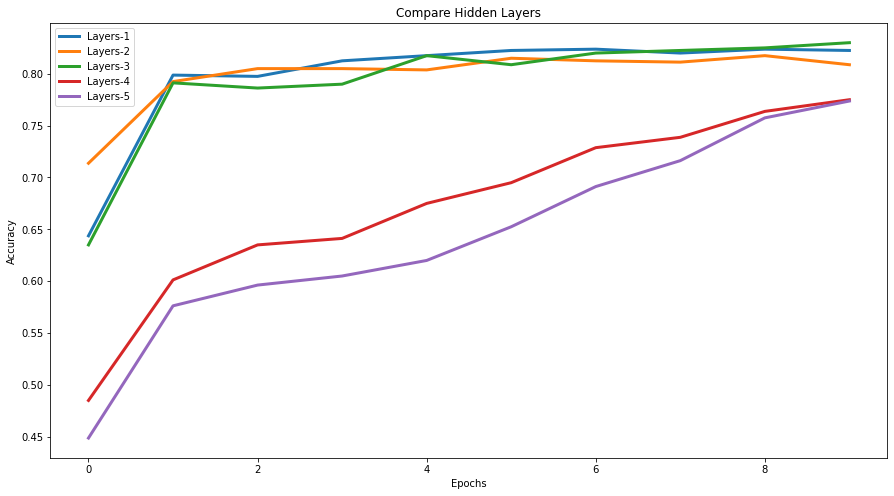

In [36]:
plot_graph(accuracy_measures, "Compare Hidden Layers")
#the best option is layer 2 with the highest accuracy with little epochs in this run. Could variate 

### 5.3.2 Nodes in a Layer

In [37]:
accuracy_measures = {}

node_increment=8

for node_count in range(1,5):
    
    #have 2 hidden layers in the networks as selected above
    layer_list =[]
    for layer_count in range(2):
        layer_list.append(node_count * node_increment)
    
    model_config = base_model_config()
    X,Y = get_rca_data()
    
    model_config["HIDDEN_NODES"] = layer_list
    model_name = "Nodes-" + str(node_count * node_increment)
    history=create_and_run_model(model_config,X,Y, model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "Nodes-8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 8)                 64        
                                                                 
 Dense-Layer-1 (Dense)       (None, 8)                 72        
                                                                 
 Output-Layer (Dense)        (None, 3)                 27        
                                                                 
Total params: 163
Trainable params: 163
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Nodes-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 16)                128     

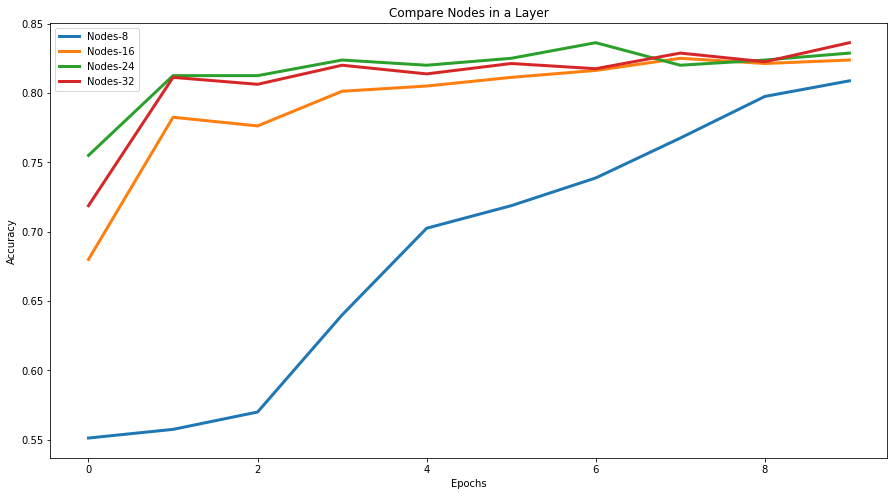

In [38]:
plot_graph(accuracy_measures, "Compare Nodes in a Layer")
#best this case 24 

## 5.4. Tuning Back Propagation

## 5.4.1. Optimizers

In [39]:
accuracy_measures = {}

optimizer_list = ['sgd','rmsprop','adam','adagrad']
for optimizer in optimizer_list:
    
    model_config = base_model_config()
    X,Y = get_rca_data()
    
    model_config["OPTIMIZER"] = optimizer
    model_name = "Optimizer-" + optimizer
    history=create_and_run_model(model_config,X,Y, model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "Optimizer-sgd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                256       
                                                                 
 Dense-Layer-1 (Dense)       (None, 64)                2112      
                                                                 
 Output-Layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 2,563
Trainable params: 2,563
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Optimizer-rmsprop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)     

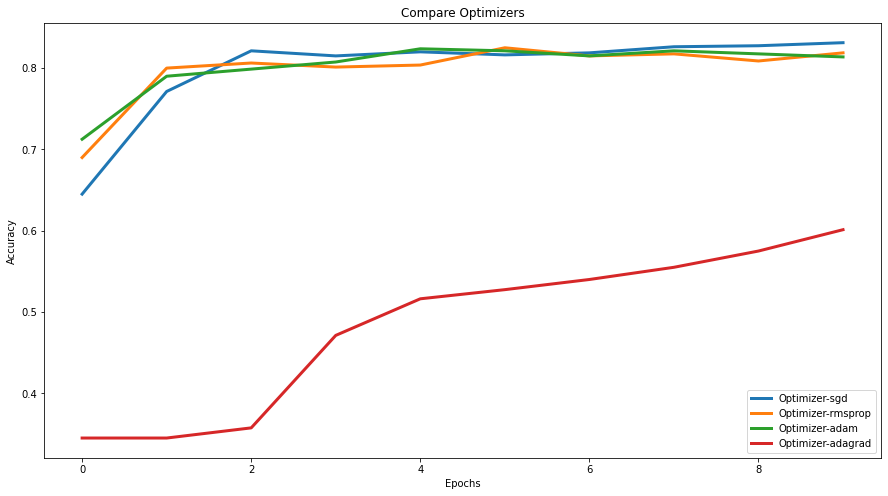

In [40]:
plot_graph(accuracy_measures, "Compare Optimizers")
#ADAM

### 5.4.2. Learning Rates

In [41]:

accuracy_measures = {}

learning_rate_list = [0.001, 0.005,0.01,0.1,0.5]
for learning_rate in learning_rate_list:
    
    model_config = base_model_config()
    X,Y = get_rca_data()
    
    #Fix Optimizer to the one chosen above
    model_config["OPTIMIZER"]="rmsprop"
    model_config["LEARNING_RATE"] = learning_rate
    model_name="Learning-Rate-" + str(learning_rate)
    history=create_and_run_model(model_config,X,Y, model_name)
    
    #Using validation accuracy
    accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "Learning-Rate-0.001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                256       
                                                                 
 Dense-Layer-1 (Dense)       (None, 64)                2112      
                                                                 
 Output-Layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 2,563
Trainable params: 2,563
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Learning-Rate-0.005"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 

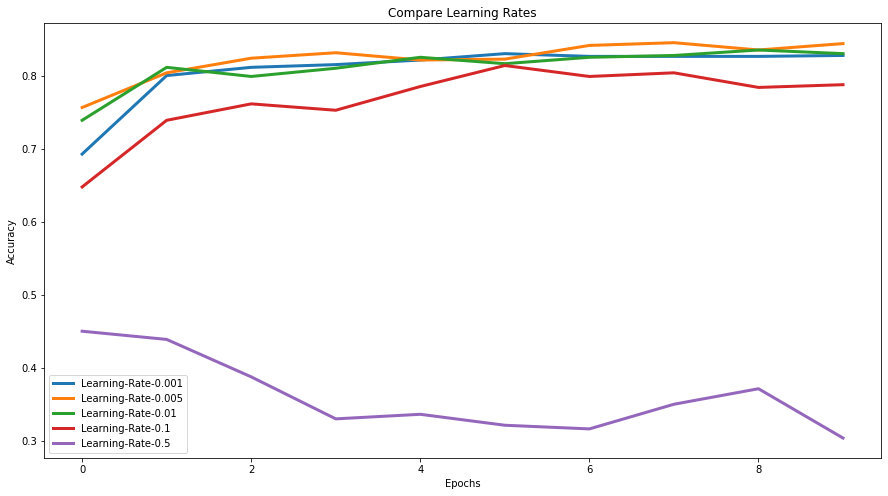

In [42]:
plot_graph(accuracy_measures, "Compare Learning Rates")
#0.01

## 5.5. Avoiding Overfitting

### 5.5.1. Regularizer

In [43]:
accuracy_measures = {}

regularizer_list = [None,'l1','l2','l1_l2']
for regularizer in regularizer_list:
    
    model_config = base_model_config()
    X,Y = get_rca_data()
    
    model_config["REGULARIZER"] = regularizer
    model_name = "Regularizer-" + str(regularizer)
    history=create_and_run_model(model_config,X,Y, model_name)
    
    #Switch to validation accuracy
    accuracy_measures[model_name] = history.history["val_accuracy"]


******************************************************
Model: "Regularizer-None"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                256       
                                                                 
 Dense-Layer-1 (Dense)       (None, 64)                2112      
                                                                 
 Output-Layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 2,563
Trainable params: 2,563
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Regularizer-l1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)     

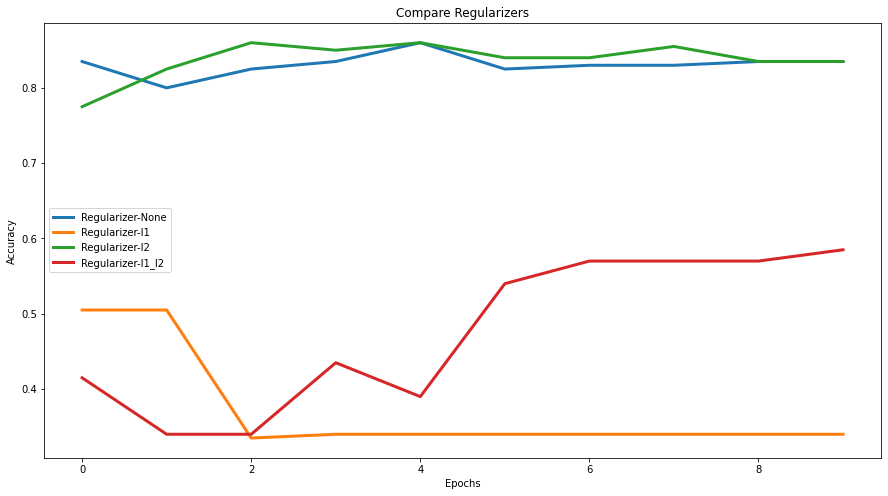

In [44]:
plot_graph(accuracy_measures, "Compare Regularizers")
#L2

### 5.5.2. Dropout

In [45]:
accuracy_measures = {}

dropout_list = [0.0, 0.1, 0.2, 0.5]
for dropout in dropout_list:
    
    model_config = base_model_config()
    X,Y = get_rca_data()
    
    #Use the regularizer chosen above
    model_config["REGULARIZER"] = "l2"
    model_config["DROPOUT_RATE"] = dropout
    model_name="Dropout-" + str(dropout)
    history=create_and_run_model(model_config,X,Y, model_name)
    
    #Using validation accuracy
    accuracy_measures[model_name] = history.history["val_accuracy"]


******************************************************
Model: "Dropout-0.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                256       
                                                                 
 Dense-Layer-1 (Dense)       (None, 64)                2112      
                                                                 
 Output-Layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 2,563
Trainable params: 2,563
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Dropout-0.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)             

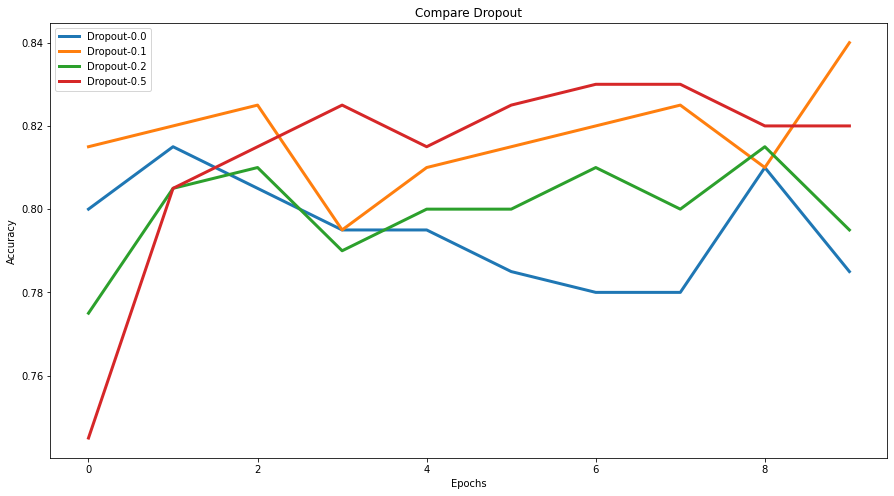

In [46]:
plot_graph(accuracy_measures, "Compare Dropout")
#0.5, #0.0

## 5.6. Building the final model

In [47]:
accuracy_measures = {}

#Base Minimal Model
model_config = base_model_config()
model_config["HIDDEN_NODES"] = [16]
model_config["NORMALIZATION"] = None
model_config["OPTIMIZER"] = "rmsprop"
model_config["LEARNING_RATE"] = 0.001
model_config["REGULARIZER"]=None
model_config["DROPOUT_RATE"] = 0.0

X,Y = get_rca_data()

model_name = "Base-Model-" + str(layer_count)

history=create_and_run_model(model_config,X,Y,model_name)
    
accuracy_measures[model_name] = history.history["accuracy"]

#Adding all optimizations
model_config = base_model_config()
model_config["HIDDEN_NODES"] = [32,32]
model_config["NORMALIZATION"] = "batch"
model_config["OPTIMIZER"] = "rmsprop"
model_config["LEARNING_RATE"] = 0.001
model_config["REGULARIZER"]="l2"
model_config["DROPOUT_RATE"] = 0.2

X,Y = get_rca_data()

model_name = "Optimized-Model-" + str(layer_count)

history=create_and_run_model(model_config,X,Y,model_name)
    
accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "Base-Model-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 16)                128       
                                                                 
 Output-Layer (Dense)        (None, 3)                 51        
                                                                 
Total params: 179
Trainable params: 179
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Optimized-Model-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                256       
                                                                 
 batch_normalization_2 (Batc  (None, 32)         

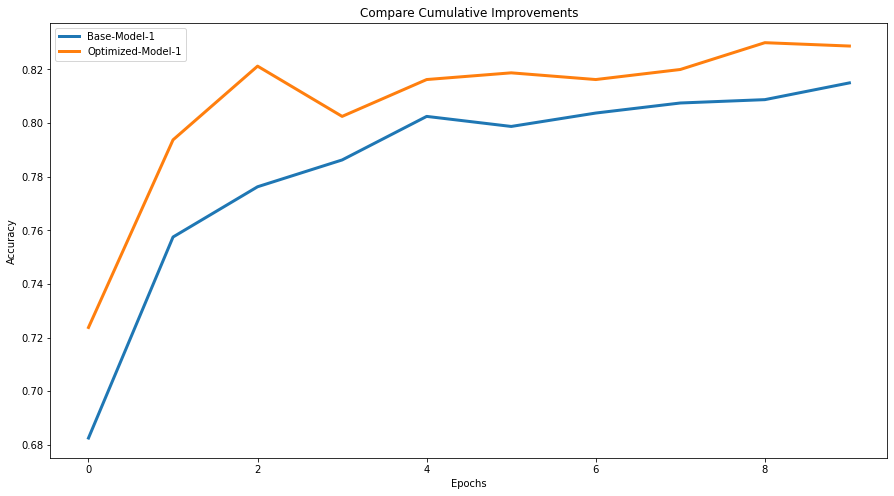

In [48]:
plot_graph(accuracy_measures, "Compare Cumulative Improvements")

In [ ]:
#now in a matrix.

optimizations=["HIDDEN_NODES","NODES","NORMALIZATION","OPTIMIZER","LEARNING_RATE","REGULARIZER","DROPOUT_RATE"] 
accuracy_measures=['accuracy_measures']

In [ ]:
accuracy_measures = {}
layer_list =[]
for layer_count in range(1,6):
    
    #32 nodes in each layer
    layer_list.append(32)
    
    model_config = base_model_config()
    X,Y = get_rca_data()
    
    model_config["HIDDEN_NODES"] = layer_list
    model_name = "Layers-" + str(layer_count)
    history=create_and_run_model(model_config,X,Y,model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]

accuracy_measures = {}

for node_count in range(8,40,8):
    
    #have 2 hidden layers in the networks
    layer_list =[]
    for layer_count in range(2):
        layer_list.append(node_count)
    
    model_config = base_model_config()
    X,Y = get_data()
    
    model_config["HIDDEN_NODES"] = layer_list
    model_name = "Nodes-" + str(node_count)
    history=create_and_run_model(model_config,X,Y, model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]